# **Disaster Tweets Classification: NLP (LSTM)**

Table of Contents:
* [About the Data](#about)
* [Set Up](#set)
* [Exploratory Data Analysis](#eda)
* [Cleaning the Data](#clean)
* [Building the Model](#model)
* [Fitting the Model](#modelf)
* [Model Performance](#modelp)
* [Submission](#sub)
* [Conclusion](#conclusion)
* [References](#ref)

<a id="about"></a>
# **About the Data**

The dataset can be found on [Kaggle's Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview) competetion. The dataset contains 10,000 Tweets that are hand classified. The purpose of the competetion and therefore this project is to develop a model that correctly predicts which Tweets are about real disasters and which are not. When applied to real life use, a model's ability to correctly identify Tweets about real disasters is important, as certain words and phrases can be used metaphorically or ironically. For example, in the Tweet shown below, the user writes that the sky was "ABLAZE". With the photo of a beautiful sunset provided, a typical person would able to use context clues and determine that this Tweet is not about a real disaster. However, this context is not as clear to a machine learning model. 

![](http://)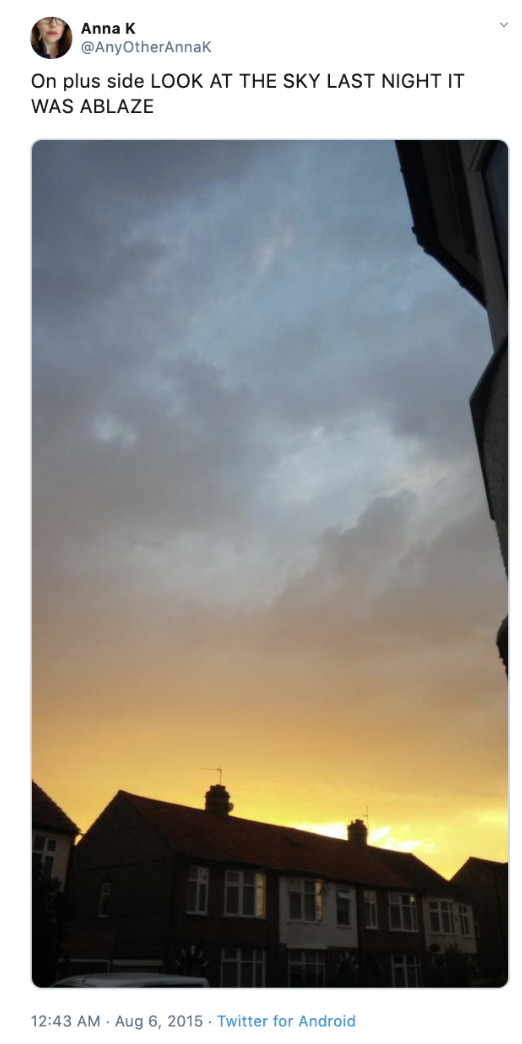

<a id="set"></a>
# **Set Up**

In [1]:
# Loading necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
!pip install pyspellchecker
from spellchecker import SpellChecker

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 8.1 MB/s eta 0:00:00


In [2]:
# Viewing available files
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt


In [3]:
# Importing train and test data
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

<a id="eda"></a>
# **Exploratory Data Analysis**

In [4]:
# Viewing a snapshot of the train dataset
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


From briefly viewing the first 5 entries in the train dataset, we can see that there are 5 columns of information: 'id', 'keyword', 'location', 'text', and 'target'. At a glimpse, it should be noted that not all entries have a keyword or a location. This is made apparent from the 'NaN' in the first 5 entries. It is also immediately clear that the 'target' column represents whether or not the Tweet is about a disaster. From the entries above, we can assume that 'target' = 1 is a disaster Tweet, as the 'text' entries include words or phrases such as "#earthquake", "Forest fire", and "shelter in place". 

In [5]:
# Viewing the info of the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Above, we can see and confirm the overall structure of the train dataset. There are 7613 entries and 5 columns, 3 of which are object type and 2 of which are int64 type. Here, we can also confirm that each entry has an 'id', 'text', and 'target'. We can also see that only 7552 entries have information in the 'keyword' column and only 5080 have information in the 'location' column. 

In [6]:
# Checking number of missing values
print("Number of Missing Values in Train: ")
print(train.isna().sum())

Number of Missing Values in Train: 
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


To confirm our previous findings, we can also check for the exact number of missing values. Here, we can see that the Train dataset has 61 null values in 'keyword' and 2533 in 'location'. 

In [7]:
# Viewing the info of the test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


Here, we can see that the test dataset is much smaller, with only 3263 entries and only 4 columns. As this is the test dataset, the 'target' column has been removed.

<Axes: xlabel='target', ylabel='count'>

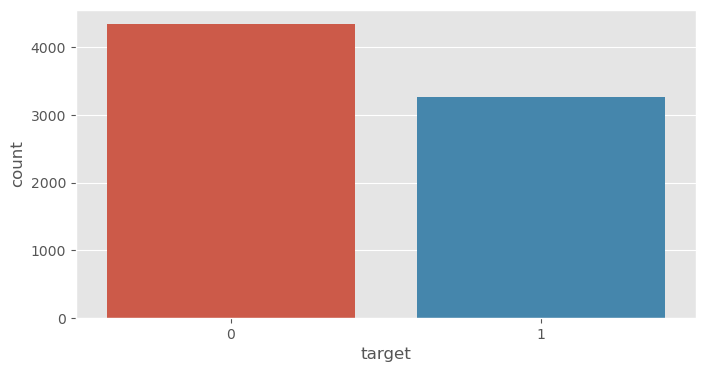

In [8]:
# Viewing the distribution of 'target' classes
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(data=train, x='target', ax=ax)

Above, we can now see the distribution of the classes in 'target'. From this chart, we can see that there are more Tweets in class 0 (no disaster) and less Tweets in class 1 (yes disaster). 

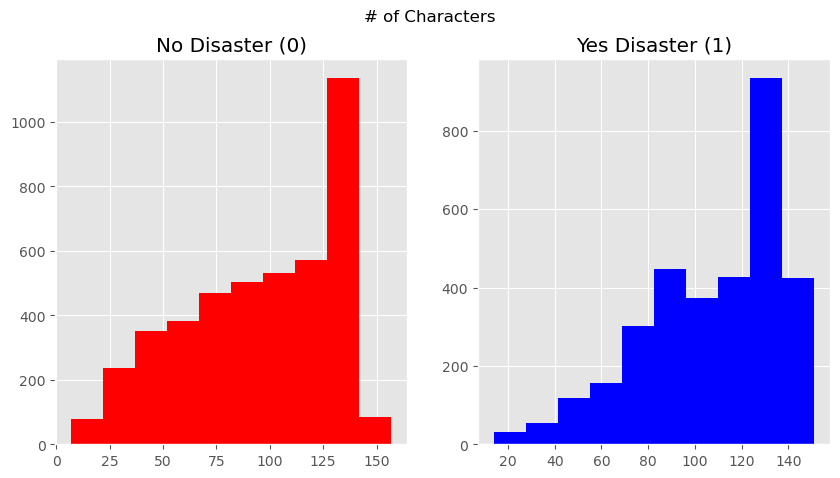

In [9]:
# Viewing the distribution of the number of characters in Tweets
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
characters = train[train['target']==0]['text'].str.len()
ax1.hist(characters,color='red')
ax1.set_title('No Disaster (0)')
characters = train[train['target']==1]['text'].str.len()
ax2.hist(characters,color='blue')
ax2.set_title('Yes Disaster (1)')
fig.suptitle('# of Characters')
plt.show()

Here, we can view the distribution of the number of characters for both classes of Tweets. Both classes exhibit a large distribution of Tweets that are close to the 140 character limit. Overall, the distribution of characters for disaster and non disaster Tweets are similar. However, non disaster Tweets appear to have a slighly higher distribution of Tweets with fewer characters, i.e. from ~20 to ~100 characters. One possible explanation for this would be that disaster Tweets rarely have smaller numbers of characters, as it may take more characters to effectively convey or describe a disaster. This, however, is simply postulation. 

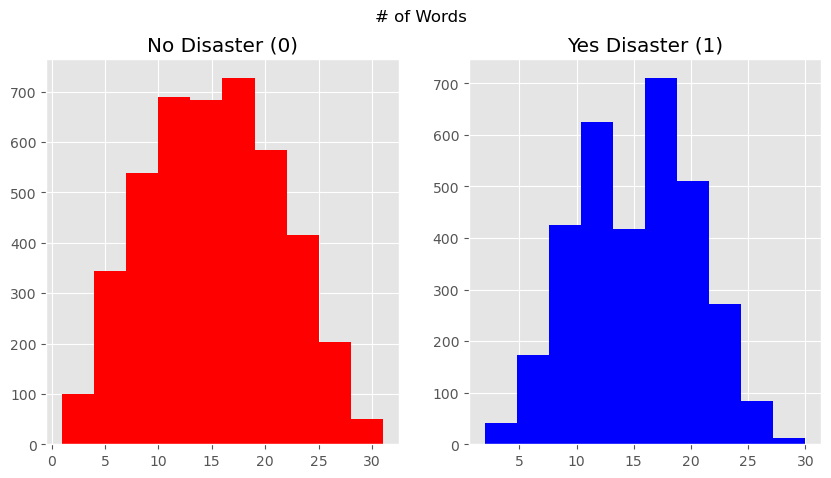

In [10]:
# Viewing the distribution of the number of words in Tweets
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
words = train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(words,color='red')
ax1.set_title('No Disaster (0)')
words = train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(words,color='blue')
ax2.set_title('Yes Disaster (1)')
fig.suptitle('# of Words')
plt.show()

The chart above shows the distribution of the number of words in the Tweets. The distributions for disaster and non disaster Tweets appear to be quite similar, with the majority of Tweets having between ~10 and ~20 words. However, it should be noted that disaster Tweets have a significantly smaller distribution of Tweets with ~15 words when compared to non disaster Tweets. 

<a id="clean"></a>
# **Cleaning the Data**

In [11]:
# Concatenating train and test datasets
data = pd.concat([train,test])
data.shape

(10876, 5)

In [12]:
# Creating function to remove URLs
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [13]:
# Testing remove_url function
example = "This competetion and dataset can be found at: https://www.kaggle.com/competitions/nlp-getting-started/overview"
print(remove_url(example))

This competetion and dataset can be found at: 


In [14]:
# Removing URLs from data
data['text'] = data['text'].apply(lambda x: remove_url(x))

In [15]:
# Creating function to remove HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

In [16]:
# Testing remove_html function
example = """<div>
<h1> Apples or Oranges <h/1>
<p> Wikipedia </p> </div>
"""
print(remove_html(example))


 Apples or Oranges 
 Wikipedia  



In [17]:
# Removing HTML tags from data
data['text'] = data['text'].apply(lambda x: remove_html(x))

In [18]:
# Creating function to remove emojis, adapted from: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [19]:
# Testing remove_emoji function
example = "I hope this function works 😔😔"
print(remove_emoji(example))

I hope this function works 


In [20]:
# Removing emojis from data
data['text'] = data['text'].apply(lambda x: remove_emoji(x))

In [21]:
# Creating function to remove punctuation
def remove_punct(text):
    punct = str.maketrans('','',string.punctuation)
    return text.translate(punct)

In [22]:
# Testing remove_punct function
example = """ I need to eat!
I am hungry.
I want #food
"""
print(remove_punct(example))

 I need to eat
I am hungry
I want food



In [23]:
# Removing punctuation from data
data['text'] = data['text'].apply(lambda x: remove_punct(x))

In [24]:
# Checking fully cleaned text
data['text'].head()

0    Our Deeds are the Reason of this earthquake Ma...
1                Forest fire near La Ronge Sask Canada
2    All residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    Just got sent this photo from Ruby Alaska as s...
Name: text, dtype: object

The data cleaning steps above have accomplished the following:
- Removed URLs
- Removed HTML tags
- Removed emojis
- Removed punctuation

By applying the cleaning functions above, our dataset is now more streamline and thus should fit the future model better. Above, we can see a quick look at the newly cleaned data. There are now no miscellaneous characters in the text. 

<a id="model"></a>
# **Building the Model**

In [25]:
# Setting up GloVe pretrained corpus model, creating create_corpus function
def create_corpus(data):
    corpus = []
    for train in tqdm(data['text']):
        words = [word.lower() for word in word_tokenize(train) if ((word.isalpha()==1)&(word not in stop))]
        corpus.append(words)
    return corpus

In [26]:
# Applying create_corpus function to data
corpus = create_corpus(data)

100%|██████████| 10876/10876 [00:02<00:00, 4054.11it/s]


In [27]:
# Opening and applying GloVe
embedding_dict={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

The code chunks above help set up our GloVe (Global Vectors for Word Representation) model. [GloVe](https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation) is an unsupervised model that can be used to obtain vector representations for words. According to the creators of GloVe, the training is performed on "aggregated global word-word co-occurrence statistics from a corpus" ([GloVe](https://nlp.stanford.edu/projects/glove/)). In other words, the GloVe model assists in determining the probability that two words appear together. In the code chunk above, we have opted to use 100-dimensional pre trained word vectors. 

In [28]:
# Creating and applying tokenizer
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)
train_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [29]:
# Using tokenizer to find the number of unique words
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [30]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 251330.83it/s]


The code chunks above perform tokenization. In other words, the text in the dataset is now in a format that is easier to convert into integers. This will be helpful when developing the model. Through this process, we can also see that there are 20342 unique words found in the Tweets. 

In [31]:
# Creating the model
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [32]:
# Viewing the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2034300   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


Above, we can see the overall structure of the model. This particular model is relatively simple, as this is my first attempt at developing RNNs (Recurrent Neural Networks) with LSTM (Long-Short Term Memory). The benefit of using LSTM here is that it will help tackle the vanishing gradient problem that is persistent in typical RNNs. The model above includes the embedding, a dropout layer, a LSTM layer, and a dense layer at the end. It should also be noted that the dense layer uses a sigmoid as the activation function. This model also employs the use of the Adam optimizer and a learning rate of 0.00001. As the learning rate for this model is relatively small, we will need to train on a larger number of epochs to get a better idea of how the weights change with each iteration. The total number of parameters is 2,076,605 with only 42,305 being trainable. 

<a id="modelf"></a>
# **Fitting the Model**

In [33]:
# Creating new datasets
train1 = train_pad[:train.shape[0]]
test1 = train_pad[train.shape[0]:]

In [34]:
# Applying train test split to data
X_train, X_test, y_train, y_test = train_test_split(train1, train['target'].values, test_size = 0.20, random_state = 42)
print('Train shape: ', X_train.shape)
print('Test shape: ', X_test.shape)

Train shape:  (6090, 50)
Test shape:  (1523, 50)


In [35]:
# Fitting the data to the model
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
1523/1523 - 68s - loss: 0.6910 - accuracy: 0.5670 - val_loss: 0.6851 - val_accuracy: 0.5739 - 68s/epoch - 45ms/step
Epoch 2/15
1523/1523 - 63s - loss: 0.6092 - accuracy: 0.6829 - val_loss: 0.5451 - val_accuracy: 0.7708 - 63s/epoch - 41ms/step
Epoch 3/15
1523/1523 - 63s - loss: 0.5554 - accuracy: 0.7450 - val_loss: 0.5211 - val_accuracy: 0.7663 - 63s/epoch - 42ms/step
Epoch 4/15
1523/1523 - 63s - loss: 0.5331 - accuracy: 0.7570 - val_loss: 0.5060 - val_accuracy: 0.7754 - 63s/epoch - 42ms/step
Epoch 5/15
1523/1523 - 62s - loss: 0.5284 - accuracy: 0.7583 - val_loss: 0.4951 - val_accuracy: 0.7794 - 62s/epoch - 41ms/step
Epoch 6/15
1523/1523 - 62s - loss: 0.5154 - accuracy: 0.7649 - val_loss: 0.4869 - val_accuracy: 0.7892 - 62s/epoch - 41ms/step
Epoch 7/15
1523/1523 - 62s - loss: 0.5086 - accuracy: 0.7662 - val_loss: 0.4787 - val_accuracy: 0.7873 - 62s/epoch - 41ms/step
Epoch 8/15
1523/1523 - 69s - loss: 0.5005 - accuracy: 0.7719 - val_loss: 0.4733 - val_accuracy: 0.7899 - 69s/ep

<a id="modelp"></a>
# **Model Performance**

In [36]:
# Creating plot function
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

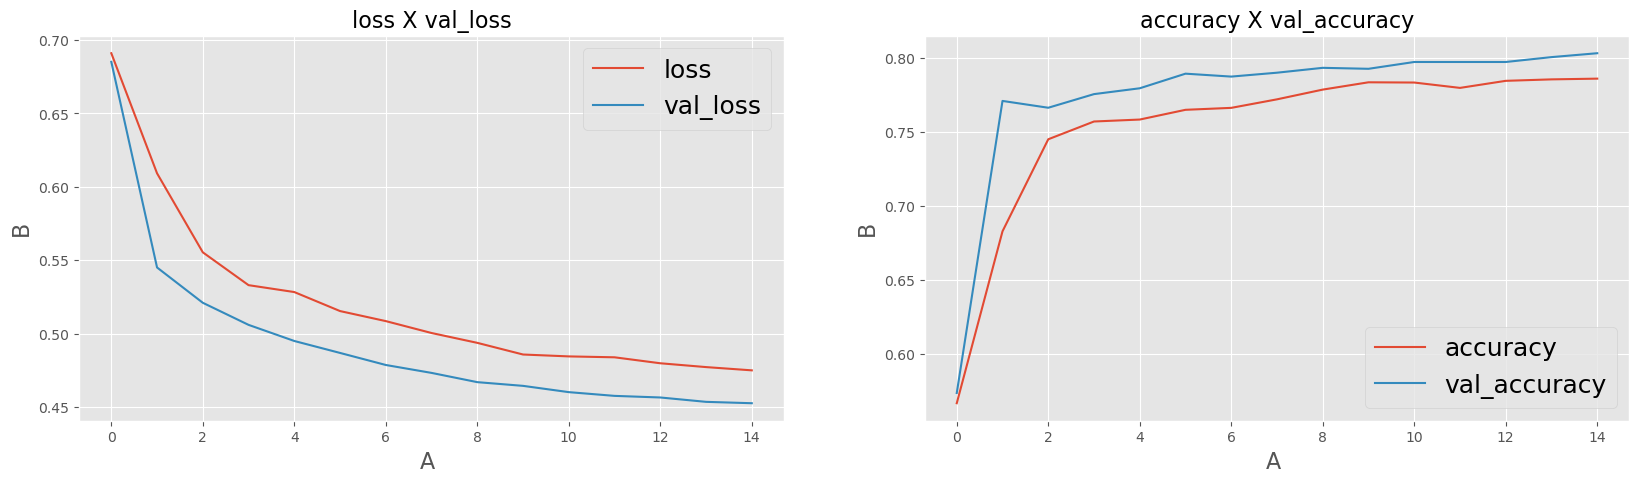

In [37]:
# Plotting model performance
plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

From the figures above, we can view the performance of our model. Below are the best results:

- Accuracy: 0.7862, epoch=15
- Validation Accuracy: 0.7997, epoch=15
- Loss: 0.4760, epoch=15
- Validation Loss: 0.45, epoch=15

From the results above, we can see that the 15th epoch yielded the best results. However, similar performance was experienced around the 10th epoch and then began to have diminishing returns. Due to this, it may not be necessary or worth it to continue to the 15th epoch if one were to factor in the time and cost of computation. In contrast, a Kaggle GPU could be used here to measure the performance of a larger number of epochs. Furthermore, a smaller batch size could be used to obtain more granular results. This would also likely require the use of a GPU. 

<a id="sub"></a>
# **Submission**

In [38]:
# Loading in sample submission
sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [39]:
# Creating submission
y_sub=model.predict(test1)
y_sub=np.round(y_sub).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_sub})
sub.to_csv('submission.csv',index=False)

102/102 [==============================] - 2s 13ms/step


In [40]:
# Viewing submission dataset
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


<a id="conclusion"></a>
# **Conclusion**

The model created in this project yielded a score of 0.78823 on the Kaggle competition. As this is my first attempt at creating a RNN with LTSM, I am quite proud of the result. Again, the model used here included only 4 layers. Significant parameters here include the sigmoid activation function in the dense layer, an LSTM layer to avoid the vanishing gradient problem, an Adam optimizer, binary crossentropy for loss, and a relatively small learning rate of 0.00001. 

After submitting my results to Kaggle, I looked at other attempts with higher scores. If I were to further develop my model I would likely opt to include or try the following:

- More dense layers with a relu activation function
- A different optimizer, such as 'rmsprop'
- Batch Normalization
- GlobalMaxPool1D

Apart from this, I could simply opt to make small tweaks to my existing model, such as using more epochs (>15) and a smaller batch size. As mentioned previously, this may provide more granular results, but I would likely need to use a Kaggle GPU to reduce the run time of this project. 

Thank you for taking the time to view my project! If you found it interesting, please feel free to leave a like! :)

<a id="ref"></a>
# **References**

- https://www.kaggle.com/competitions/nlp-getting-started/overview
- https://www.kaggle.com/code/moazeldsokyx/disaster-tweets-classification-nlp
- https://www.kaggle.com/code/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/notebook
- https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove/notebook#Data-Cleaning
- https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
- https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation
- https://nlp.stanford.edu/projects/glove/